# Identifying matches in pairs of validated floe images

To test the variation in measures across multiple images, we'll look at paired ice floes. 

# Example case
166-laptev_sea-20160904-aqua-labeled_floes

In [1]:
import skimage as sk
import proplot as pplt
import numpy as np
import os

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
tc_aqua = "../data/modis/truecolor/166-laptev_sea-100km-20160904.aqua.truecolor.250m.tiff"
tc_terra = "../data/modis/truecolor/166-laptev_sea-100km-20160904.terra.truecolor.250m.tiff"
lb_aqua = "../data/validation_images/labeled_floes/166-laptev_sea-20160904-aqua-labeled_floes.tiff"
lb_terra = "../data/validation_images/labeled_floes/166-laptev_sea-20160904-terra-labeled_floes.tiff"

# tc_aqua = "../data/modis/truecolor/160-laptev_sea-100km-20170528.aqua.truecolor.250m.tiff"
# tc_terra = "../data/modis/truecolor/160-laptev_sea-100km-20170528.terra.truecolor.250m.tiff"
# lb_aqua = "../data/validation_images/labeled_floes/160-laptev_sea-20170528-aqua-labeled_floes.png"
# lb_terra = "../data/validation_images/labeled_floes/160-laptev_sea-20170528-terra-labeled_floes.png"


tc_aqua = sk.io.imread(tc_aqua)
tc_terra = sk.io.imread(tc_terra)
tc_aqua = sk.color.rgba2rgb(tc_aqua)
tc_terra = sk.color.rgba2rgb(tc_terra)
lb_aqua = sk.io.imread(lb_aqua).astype(int)[:,:,0]
lb_terra = sk.io.imread(lb_terra).astype(int)[:,:,0]

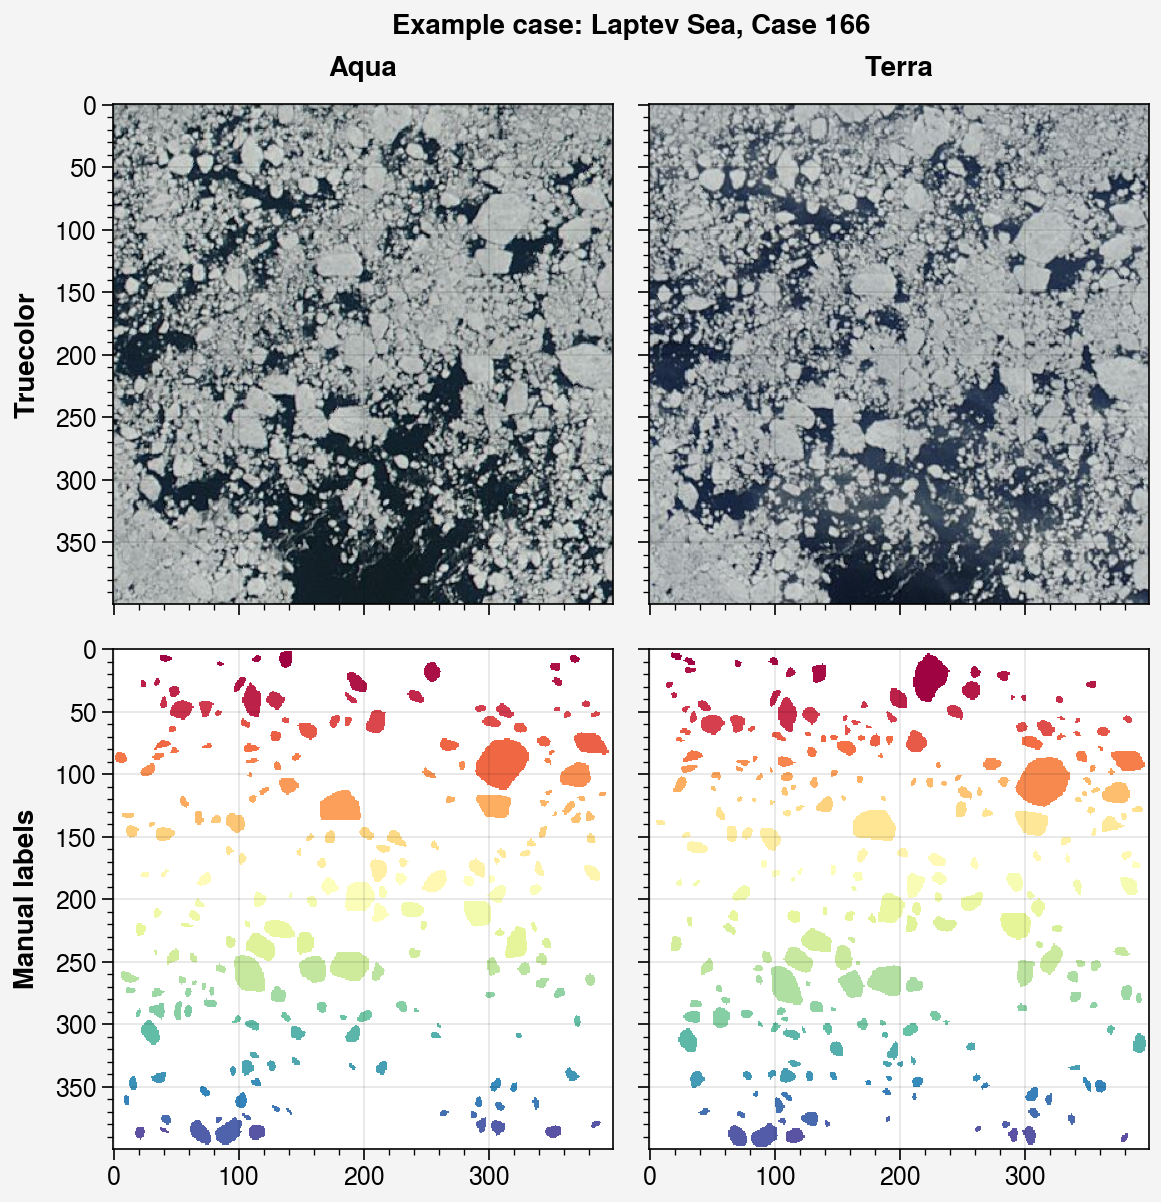

In [42]:
lbmask = lambda im: np.ma.masked_array(im, mask=im==0)

fig, ax = pplt.subplots(ncols=2, nrows=2)
ax[0].imshow(tc_aqua)
ax[1].imshow(tc_terra)
ax[2].imshow(lbmask(lb_aqua), cmap='spectral')
ax[3].imshow(lbmask(lb_terra), cmap='spectral')

ax.format(suptitle="Example case: Laptev Sea, Case 166",
          leftlabels=['Truecolor', 'Manual labels'], toplabels=['Aqua', 'Terra'])
fig.save("../figures/optical_flow_example_4x4_166.png", dpi=300)

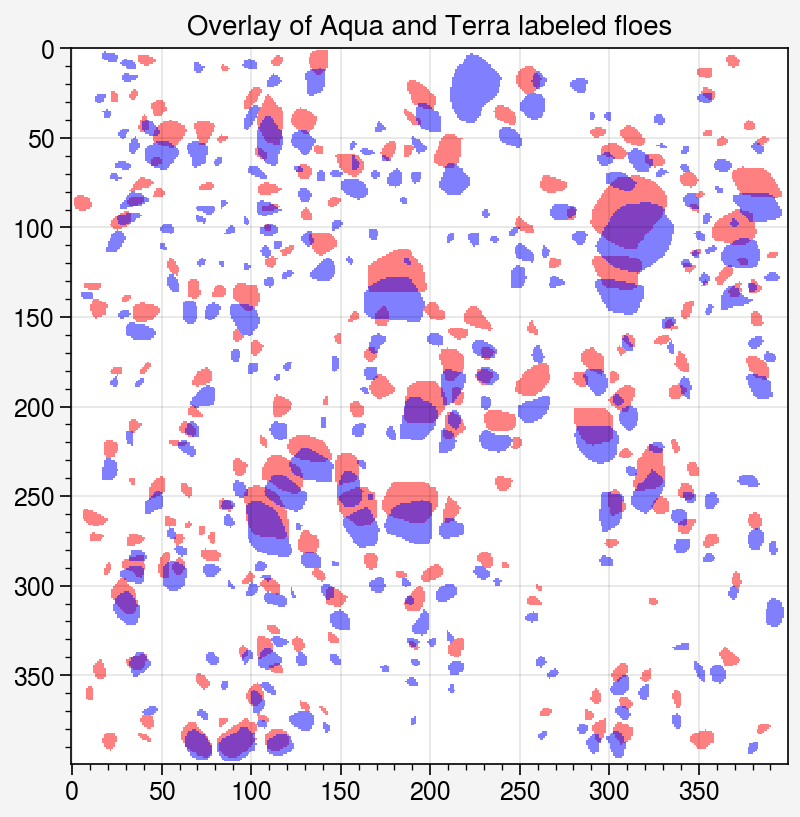

In [23]:
import proplot as pplt
import numpy as np
fig, ax = pplt.subplots(width=4)
ax.imshow(lbmask(lb_aqua), vmin=0, vmax=1, color='r', alpha=0.5)
ax.imshow(lbmask(lb_terra), vmin=0, vmax=1, color='b', alpha=0.5)
ax.format(title='Overlay of Aqua and Terra labeled floes')

Overlapping the images shows that the floes move enough that we can't just look for an overlap, and we also know that there's differences in the velocity across the image. We can enhance contrast in the original image by using the floes as a mask.

In [5]:
im1 = sk.color.rgb2gray(tc_aqua)
im2 = sk.color.rgb2gray(tc_terra)
v, u = sk.registration.optical_flow_ilk(reference_image=im1,
                                      moving_image=im2,
                                      radius=7,
                                      num_warp=10,
                                      gaussian=False, prefilter=False)
v0, u0 = sk.registration.optical_flow_tvl1(im1, im2)

In [6]:
nr, nc = im1.shape
row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
im2_warp = sk.transform.warp(im2, np.array([row_coords + v, col_coords + u]), order=0, mode='constant', cval=0)

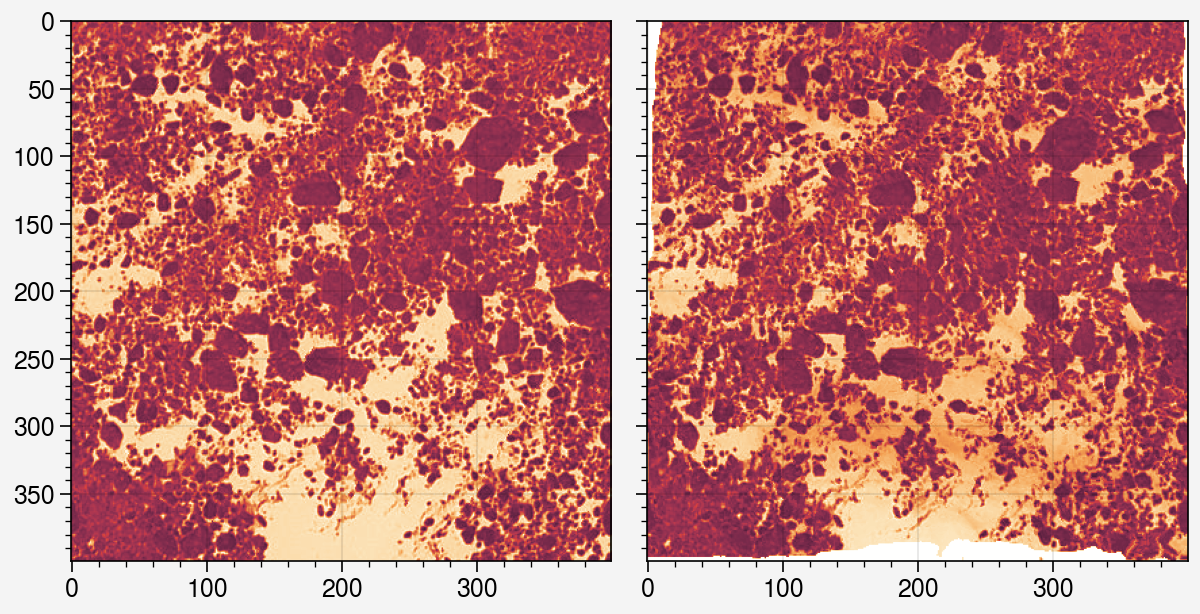

In [7]:
fig, ax = pplt.subplots(width=6, ncols=2)
ax[0].imshow(im1)
ax[1].imshow(im2_warp)

In [9]:
lb_terra_ = sk.measure.label(lb_terra)
lb_warp = sk.transform.warp(lb_terra_[:,:], np.array([row_coords + v, col_coords + u]), order=0, mode='constant', cval=0)

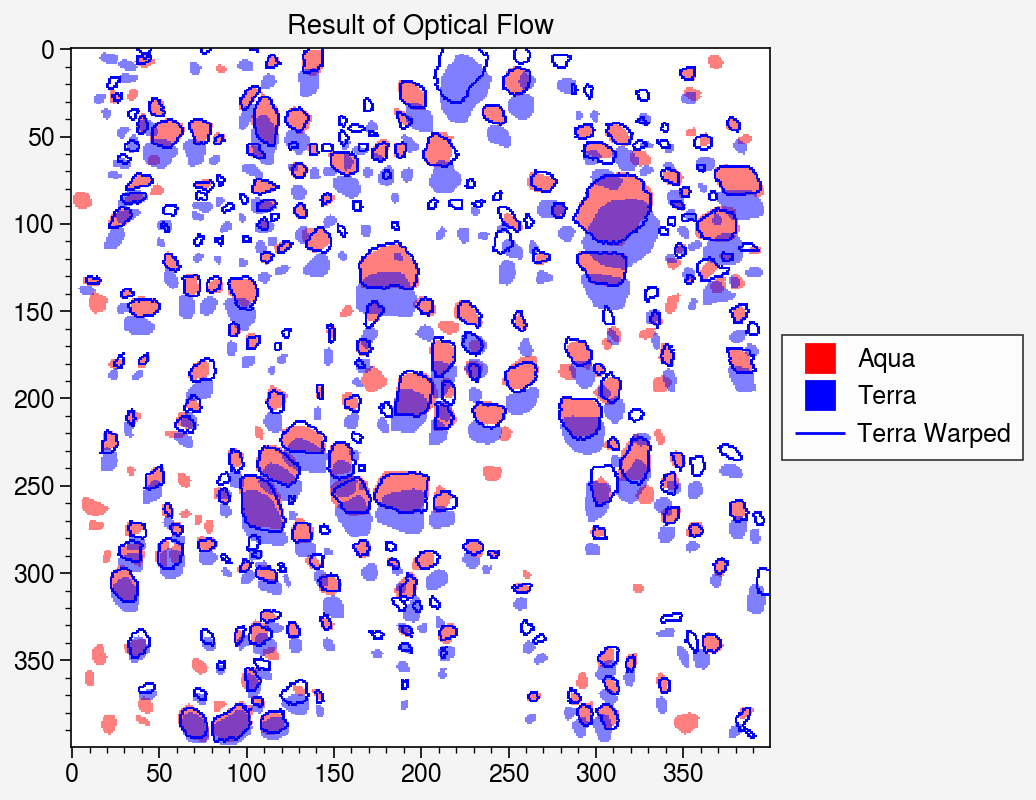

In [26]:
import proplot as pplt
import numpy as np
d = sk.morphology.disk(1)
fig, ax = pplt.subplots(height=4)
ax.pcolormesh(lbmask(lb_aqua), vmin=0, vmax=1, color='r', alpha=0.5)
ax.pcolormesh(lbmask(lb_terra), vmin=0, vmax=1, color='b', alpha=0.5)
ax.pcolormesh(lbmask(lb_warp - sk.morphology.erosion(lb_warp, footprint=d)), c='b', alpha=1)
for c, lw, ms, lb in zip(['r', 'b', 'b'], [0, 0, 1], [10, 10, 0], ['Aqua', 'Terra', 'Terra Warped']):
    ax.plot([], [], color=c, lw=lw, ms=ms, m='s', label=lb)
ax.legend(loc='r', ncols=1)
ax.format(yreverse=True, title='Result of Optical Flow')
fig.save('../figures/optical_flow_example_166.png', dpi=300)

# Findings
For this "easy" image (166), and a harder image (160) optical flow works pretty well! Here's the method:
1. Apply optical flow to the true color images to find the best transform
2. Apply the transform to the labeled image using nearest neighbors and fill edges with 0
3. Pair the labeled image and the warped labeled image using the relevant set method
4. Keep only objects with a single member of the relevant set

Potentially, find the optimal rotation prior to describing the variance in shape parameters.

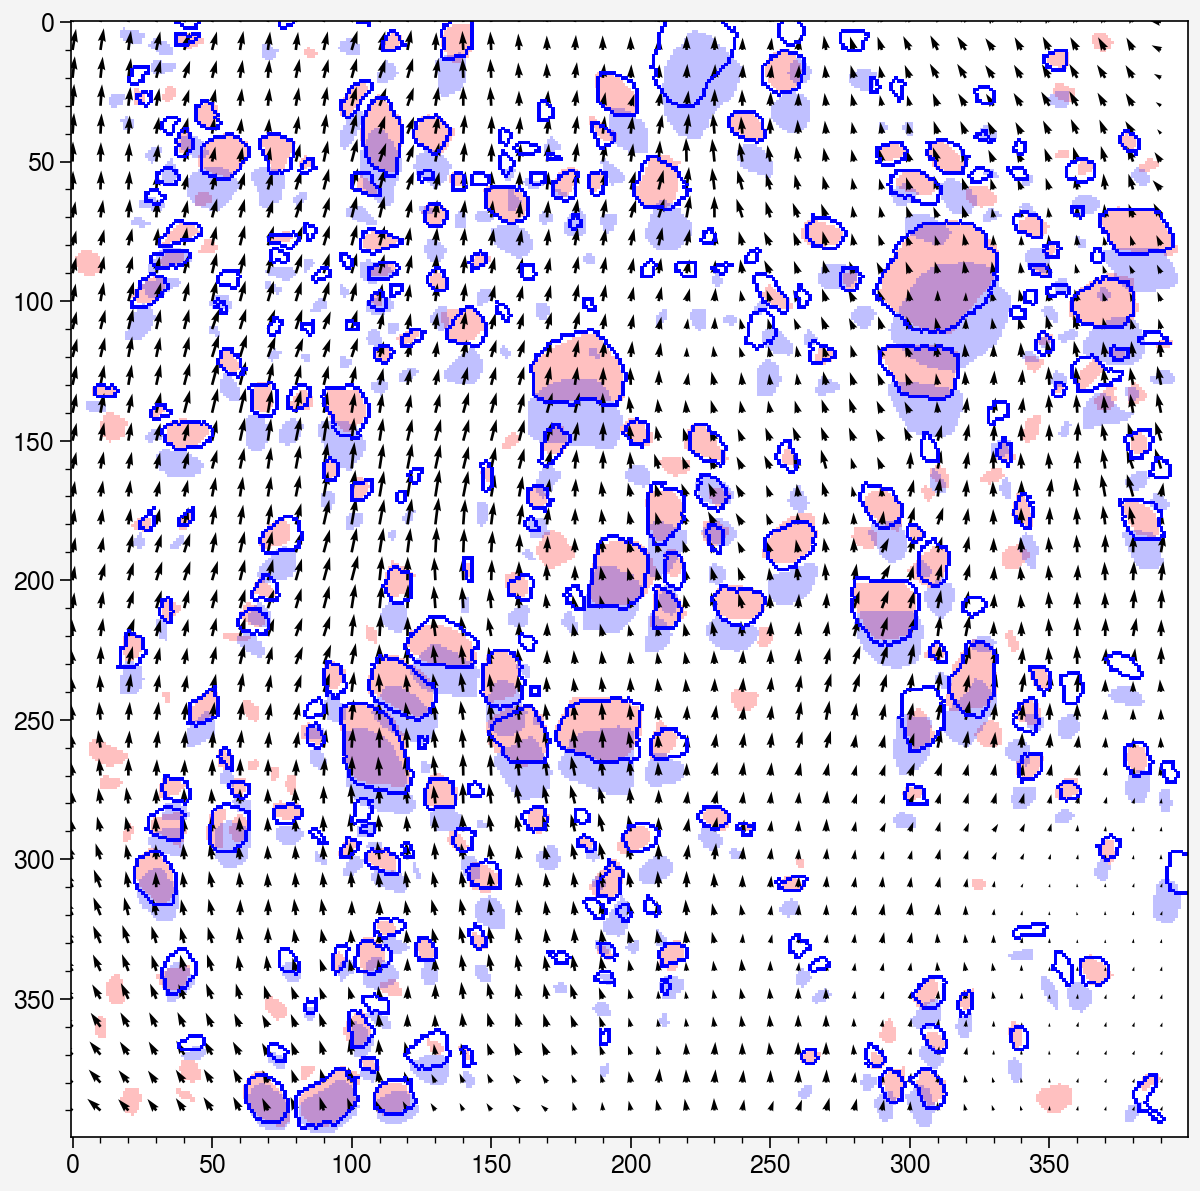

In [39]:
fig, ax = pplt.subplots(width=6)
# Need to figure out the right way to align Quiver with the image orientation convention. Some axis has to get flipped.
ax.quiver(row_coords[::10, ::10], col_coords[::10, ::10], u[::10, ::-10], v[::10, ::-10])
# ax.quiver(row_coords[::10, ::10], col_coords[::10, ::10], u0[::10, ::10], v0[::10, ::10], color='green')
ax.imshow(lbmask(lb_aqua[:,:]), vmin=0, vmax=1, color='r', alpha=0.25)
ax.imshow(lbmask(lb_terra[:,:]), vmin=0, vmax=1, color='b', alpha=0.25)
ax.pcolormesh(lbmask(lb_warp - sk.morphology.erosion(lb_warp, footprint=d)), c='b', alpha=1)
ax.format(yreverse=True)

In [40]:
# simple script: save the labeled images
import skimage as sk
import os
binary_dataloc = "../data/validation_images/binary_floes/"
files = [f for f in os.listdir(binary_dataloc) if 'png' in f]

In [41]:
im = sk.io.imread(binary_dataloc + files[0])

In [75]:
for file in files:
    im = sk.io.imread(binary_dataloc + file)
    labeled_dataloc = binary_dataloc.replace("binary", "labeled")
    labeled_im = sk.measure.label(im).astype(float)
    sk.io.imsave(labeled_dataloc + file.replace("binary", "labeled").replace("png", "tiff"), 
             labeled_im, check_contrast=False)

In [65]:
comp = sk.io.imread(labeled_dataloc + files[0].replace("binary", "labeled").replace("png", "tiff"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


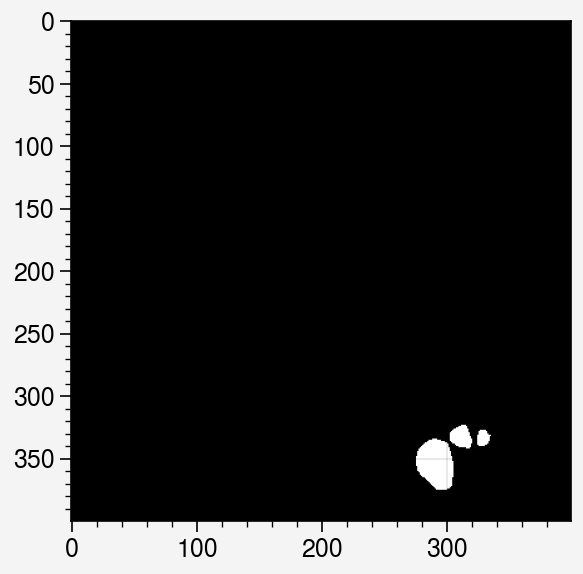

In [67]:
fig, ax = pplt.subplots()
ax.imshow(comp)

In [73]:
comp.astype(int) == test_im

array([[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       ...,

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,